# Assignemnt 4 - Convolutional Neural Network (CNN)

## 1 : Data Loading and Preprocessing

### Import necessary libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import kagglehub

In [2]:
# Download the dataset
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:02<00:00, 149MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [3]:
data_dir = path
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
test_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

# Define image dimensions
img_height, img_width = 150, 150
batch_size = 32

# Create data generators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Validation split
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Display sample images from dataset

Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


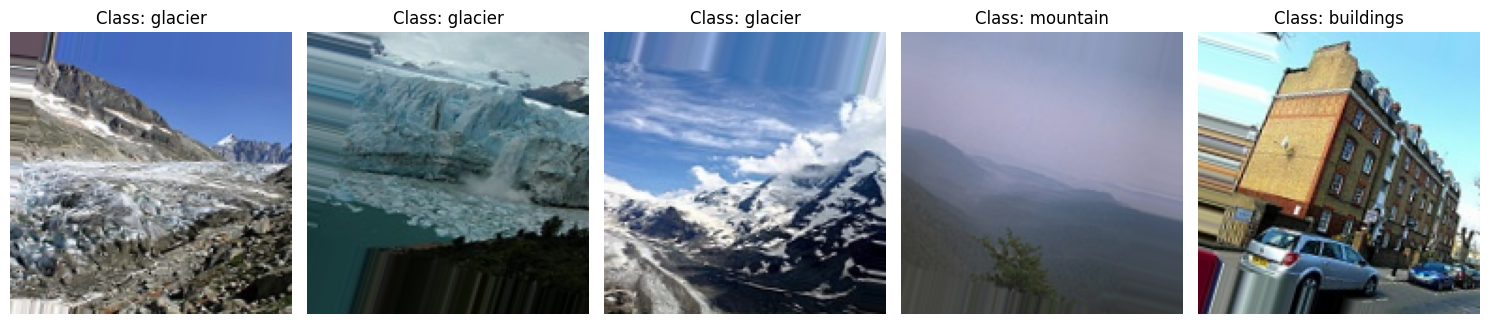

In [4]:
# Retrieve classnames
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

# Display sample images
def display_sample_images(generator, class_names, n=5):
    plt.figure(figsize=(15, 10))

    # Obtain batch of images
    images, labels = next(generator)

    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(f"Class: {class_names[label_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(train_generator, class_names)

## Model Building

In [5]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    return model

# Create CNN model
input_shape = (img_height, img_width, 3)  # 3 - RGB images
num_classes = len(class_names)
model = create_cnn_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Generate summary of model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## Train model

In [6]:
epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Save
model.save('intel_image_classifier.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 105s 277ms/step - accuracy: 0.4535 - loss: 1.3481 - val_accuracy: 0.6527 - val_loss: 0.9346
Epoch 2/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5000 - loss: 1.2080

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5000 - loss: 1.2080 - val_accuracy: 0.6369 - val_loss: 0.9669
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 104s 247ms/step - accuracy: 0.6310 - loss: 0.9558 - val_accuracy: 0.6825 - val_loss: 0.8437
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8125 - loss: 0.7988 - val_accuracy: 0.6828 - val_loss: 0.8539
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 87s 248ms/step - accuracy: 0.6840 - loss: 0.8488 - val_accuracy: 0.7310 - val_loss: 0.7240
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6250 - loss: 0.9284 - val_accuracy: 0.7421 - val_loss: 0.7008
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 142s 303ms/step - accuracy: 0.7286 - loss: 0.7576 - val_accuracy: 0.7604 - val_loss: 0.6718
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.6875 - loss: 0.7708 - val_accuracy: 0.7540 - val_loss: 0.6654
Epoch 9/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 88s 249ms/step - accuracy: 0.7600 - loss: 0.6630 - val_a

## Visualizations

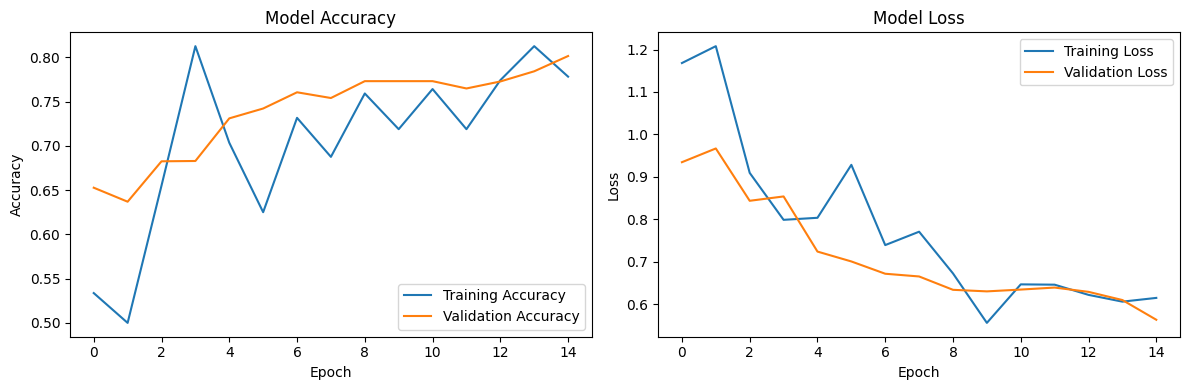

In [7]:
# Training history
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

### Model Evalutation

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8235 - loss: 0.4685
Test accuracy: 0.8320
Test loss: 0.4667


### Generate Predictions

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


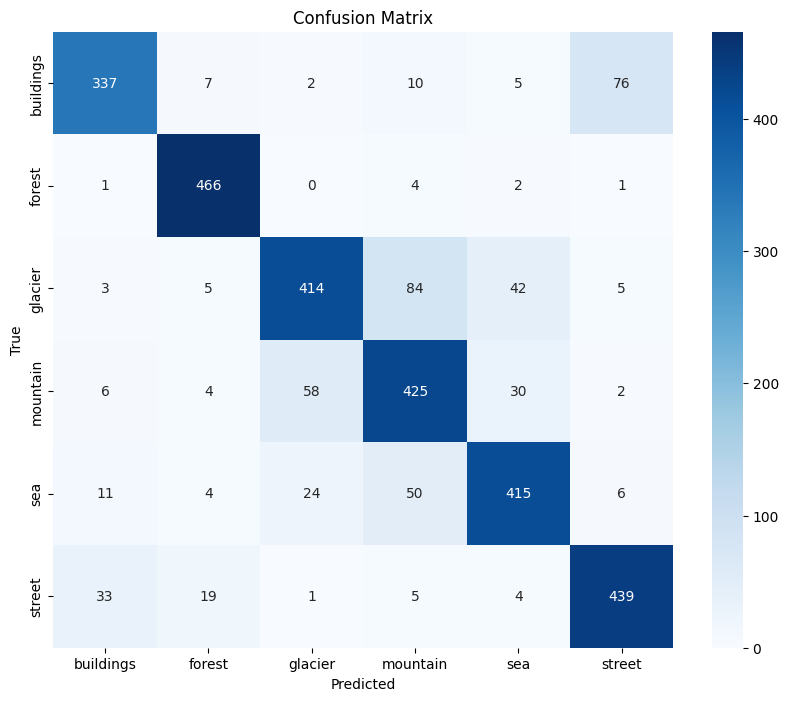

Classification Report:
              precision    recall  f1-score   support

   buildings       0.86      0.77      0.81       437
      forest       0.92      0.98      0.95       474
     glacier       0.83      0.75      0.79       553
    mountain       0.74      0.81      0.77       525
         sea       0.83      0.81      0.82       510
      street       0.83      0.88      0.85       501

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [9]:
# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

### Display misclassified images

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


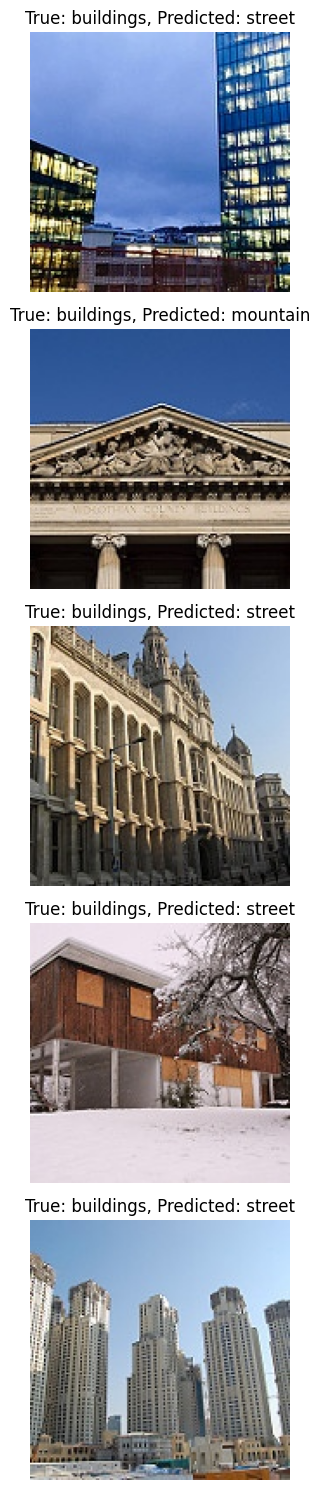

In [10]:
def display_misclassified_images(model, generator, class_names, n=5):
    generator.reset()
    images, labels = [], []

    # Collect images and labels
    for i in range(len(generator)):
        batch_images, batch_labels = next(generator)
        images.extend(batch_images)
        labels.extend(batch_labels)
        if len(images) >= 1000:  # To avoid memory issues
            break

    images = np.array(images)
    labels = np.array(labels)

    # Predict
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    # Find misclassified samples
    misclassified_indices = np.where(pred_classes != true_classes)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified images found in the sample.")
        return

    # Display misclassified images
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(misclassified_indices[:n]):
        plt.subplot(n, 1, i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true_classes[idx]]}, Predicted: {class_names[pred_classes[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_misclassified_images(model, test_generator, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


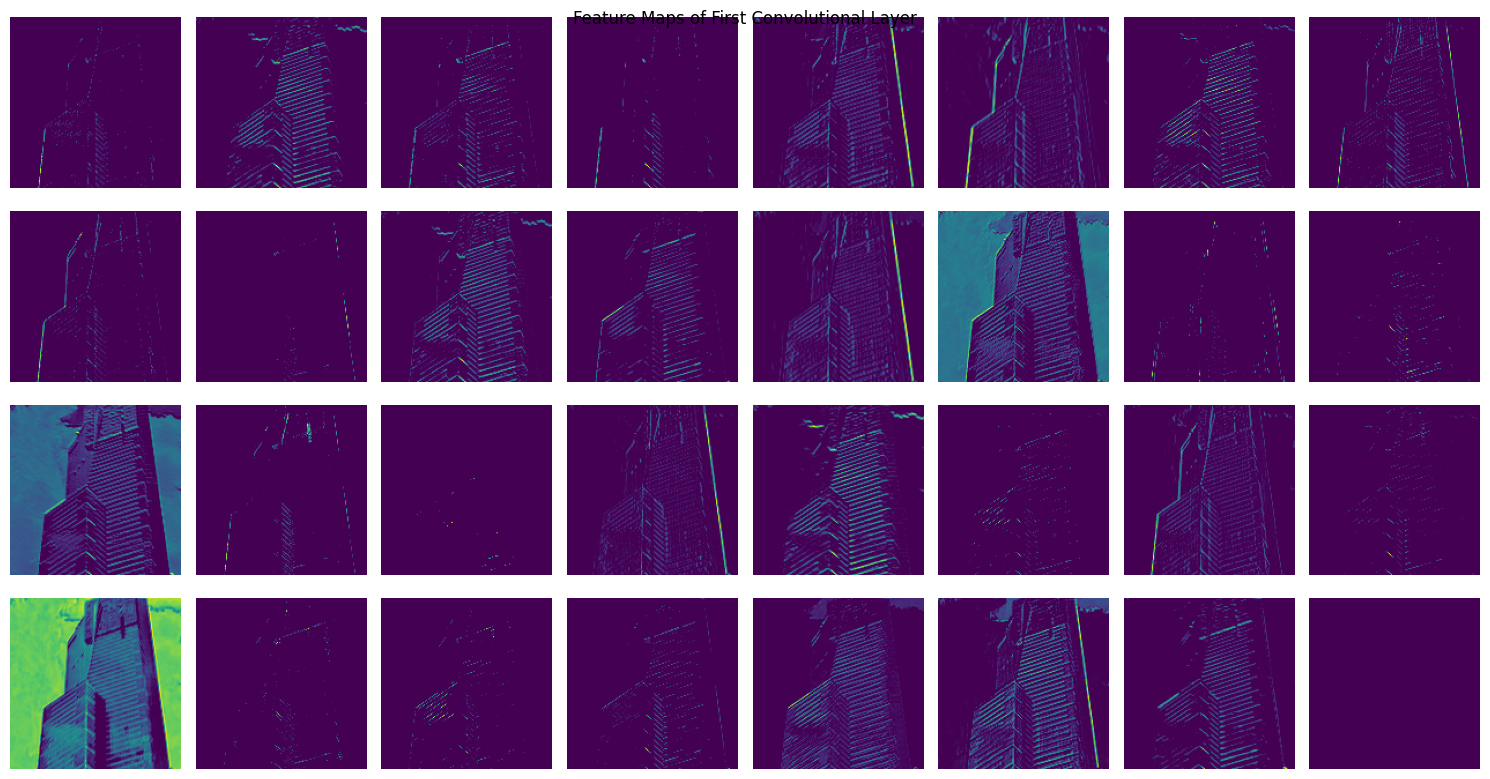

In [11]:
# Visualize feature maps of the first convolutional layer
def visualize_feature_maps(model, image):
    feature_map_model = models.Model(inputs=model.inputs, outputs=model.layers[0].output)

    # Reshape image to match input shape
    img = np.expand_dims(image, axis=0)

    # Feature maps
    feature_maps = feature_map_model.predict(img)

    # Plot feature maps
    plt.figure(figsize=(15, 8))

    for i in range(min(32, feature_maps.shape[3])):
        plt.subplot(4, 8, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Feature Maps of First Convolutional Layer')
    plt.show()

# Obtain sample image
test_generator.reset()
sample_images, _ = next(test_generator)
sample_image = sample_images[0]

# Visualize feature maps
visualize_feature_maps(model, sample_image)

In [12]:
# Performance Analysis
def analyze_model_performance():
    print("Model Performance Analysis:")
    print("--------------------------")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Calculate class-wise accuracy from confusion matrix
    class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

    print("\nClass-wise Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {class_accuracy[i]:.4f}")

    print("\nPotential Areas for Improvement:")
    print("1. Data Augmentation: Explore more robust techniques for augmenting your dataset.")
    print("2. Model Architecture: Consider experimenting with deeper networks or applying transfer learning using pre-trained models like ResNet or EfficientNet.")
    print("3. Hyperparameter Tuning: Adjust parameters such as the learning rate, batch size, and regularization settings to boost performance.")
    print("4. Ensemble Methods: Merge predictions from several models to achieve more accurate outcomes.")
    print("5. Attention Mechanisms: Integrate attention modules to better highlight the most discriminative features.")

analyze_model_performance()

Model Performance Analysis:
--------------------------
Test Accuracy: 0.8320

Class-wise Accuracy:
buildings: 0.7712
forest: 0.9831
glacier: 0.7486
mountain: 0.8095
sea: 0.8137
street: 0.8762

Potential Areas for Improvement:
1. Data Augmentation: Explore more robust techniques for augmenting your dataset.
2. Model Architecture: Consider experimenting with deeper networks or applying transfer learning using pre-trained models like ResNet or EfficientNet.
3. Hyperparameter Tuning: Adjust parameters such as the learning rate, batch size, and regularization settings to boost performance.
4. Ensemble Methods: Merge predictions from several models to achieve more accurate outcomes.
5. Attention Mechanisms: Integrate attention modules to better highlight the most discriminative features.
